In [211]:
import sys
sys.path.append('/Users/nwilming/u')
import cPickle
from conf_analysis.pupil import pupil, patsy_transforms as pt
from conf_analysis.behavior import empirical
from pylab import *
import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
data = empirical.load_data()

In [148]:
data = empirical.data_cleanup(data)

In [149]:
def session_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.day))))
    data.loc[:, 'session_num'] = data.day
    data.session_num = data.session_num.replace(lt)
    return data

def block_num(data):
    lt = dict((k, i) for i,k in enumerate(sort(unique(data.session.astype('str')))))
    data.loc[:, 'block_num'] = data.session.astype('str')
    data.block_num = data.block_num.replace(lt)
    return data

data = data.groupby('snum').apply(session_num)
data = data.groupby(['snum', 'session_num']).apply(block_num)

In [173]:
def contrast_block_mean(data):
    con = abs(vstack(data.contrast_probe)-0.5)
    m = mean(con)
    data.loc[:, 'contrast_block_mean'] = m
    return data 

data = data.groupby(['snum', 'session_num', 'block_num']).apply(contrast_block_mean)

In [177]:
def zscore_contrast(data):
    con = vstack(data.contrast_probe)
    m = mean(con)
    s = abs(con-mean(con)).std()
    idx = where(data.columns=='contrast_probe')[0][0]
    for i in range(len(data)): 
        data['contrast_probe'].values[i] = (data.iloc[i, idx]-m)/s
    data['contrast_block_mean'] = m
    data.loc[:, 'contrast'] = (data.loc[:, 'contrast']+0.5-m)/s
    return data

dz = data.copy().groupby(['snum', 'session_num', 'block_num']).apply(zscore_contrast)
dz['mc'] = array([mean(k) for k in dz.contrast_probe.values])
dz['stdc'] = array([std(k) for k in dz.contrast_probe.values])


Data checking and quality control
-------------------------------

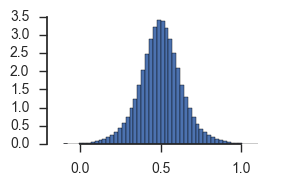

In [153]:
# Is there clipping
cs = hstack(data.contrast_probe)
sum((cs>1) | (cs<0.0))/float(len(cs))
figure(figsize=(3, 2))
_= hist(cs, linspace(-0.1, 1.1, 51), normed=True)
xticks([-0., 0.5, 1.])
sns.despine(offset=0, trim=True)
tight_layout()

__Fig S1.__ Is there any clipping of contrast values? Does not look like it. The vas majority of contrast values s within [0, 1]

#### Fix a few glitches in behavior: 
S3 confused the key ordering for high and low confidence 2nd grating in the first two sessions (20151207, 20151208). When S3 came in for the 3rd session I tested what keys S3 would press for the two options to confirm that S3 indeed confused the two keys. As predicted from the data S3 pressed the wrong keys. Upon explaining the key mapping S3 realized the mistake and confirmed that the wrong keys were used. I feel therefore confident to simply change the response here.
S11 confused key ordering during the training session (2016022). But S10 confused keys for the 1st grating

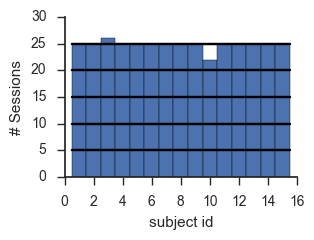

In [154]:
figure(figsize=(3, 2))
for s, sub in data.groupby('snum'):
    bar(s-0.5, len(unique(sub.session)), 1)
plot([0.5, 15.5], [25, 25], 'k')
plot([0.5, 15.5], [5, 5], 'k')
plot([0.5, 15.5], [10, 10], 'k')
plot([0.5, 15.5], [15, 15], 'k')
plot([0.5, 15.5], [20, 20], 'k')
sns.despine()
xlabel('subject id')
ylabel('# Sessions')

__ Fig S2. How many blocks are available per subject?__ Should be 25. Subject 10 is missing a few blocks because of a recording problem. Due to errors caused by the eye-tracker the data was not safed as .mat files, this was only detected after a few sessions. The cause of the error was some matlab interaction with other experiments (updated PTB or updated matlab). I'm not sure if this behavioral data can be recovered. 

Data Analysis
=======

Start by plotting confidence kernels with and without removing the mean of a trial.

In [185]:
# Compute kernel data frame
def get_pk(data, contrast_mean=0.5):
    '''
    Converts data to a data frame that is long form for different contrast probes.
    I.e. indexed by trial, time and whether contrast was for chosen or non-chosen option.
        
    normalize : Subtract some mean value per trial.
    
    ''' 
    dr1 = data.query('response==1')
    dr2 = data.query('response==-1')
    
    # Subtract QUEST mean from trials. 
    con_select2nd = vstack(dr1.contrast_probe) - contrast_mean - (dr1.contrast * dr1.side)[:, newaxis] 
    con_select1st = vstack(dr2.contrast_probe) - contrast_mean - (dr2.contrast * dr2.side)[:, newaxis]
    
    sel = vstack((con_select2nd, 0*con_select1st))
    nsel = vstack((con_select1st, 0*con_select2nd))

    
    sel = pd.DataFrame(sel)
    sel.index.name='trial'
    sel.columns.name='time'
    sel =  sel.unstack().reset_index()
    sel['optidx'] = 1
    sel = sel.set_index(['time', 'optidx', 'trial'])
    
    nsel = pd.DataFrame(nsel)
    nsel.index.name='trial'
    nsel.columns.name='time'
    nsel = nsel.unstack().reset_index()
    nsel['optidx'] = 0
    nsel = nsel.set_index(['time', 'optidx', 'trial'])
    df = pd.concat((sel, nsel))
    df.rename(columns={0:'contrast'}, inplace=True)
    return df

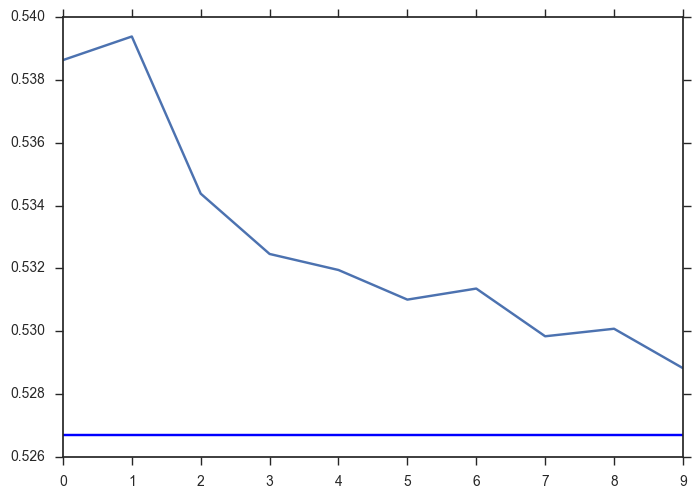

In [182]:
dr1 = data.query('response==1')
con_select2nd = vstack(dr1.contrast_probe)  #+ (dr1.contrast * dr1.side)[:, newaxis]
plot(con_select2nd.mean(0))
axhline(mean(dr1.contrast * dr1.side)+0.5)

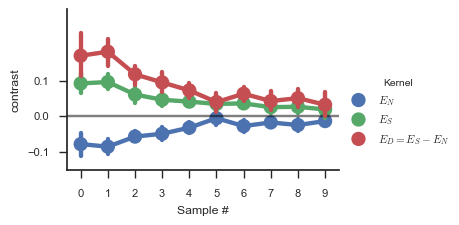

In [212]:
def get_pk_kernel(data, contrast_mean=0.5):
    kernels = []

    kernel = (data.groupby(['snum'])
         .apply(lambda x: get_pk(x, contrast_mean=contrast_mean))
         .groupby(level=['snum', 'time', 'optidx']).mean()
         .reset_index())

    kernel_diff = (data.groupby(['snum'])
         .apply(lambda x: get_pk(x, contrast_mean=contrast_mean))
         .groupby(level=['snum', 'time'])
              .apply(lambda x: x.query('optidx==1').mean()-x.query('optidx==0').mean())
         .reset_index())

    kernel_diff['optidx'] = 3
    kernel = pd.concat((kernel, kernel_diff))
    return kernel
    
kernels = get_pk_kernel(dz, contrast_mean=0.)
condition = kernels.optidx.astype('category', ordered=True)
condition = condition.cat.rename_categories([r'$E_N$', r'$E_S$', r'$E_D = E_S - E_N$'])
kernels['Kernel'] = condition

g = sns.factorplot(x='time', y='contrast', hue='Kernel', data=kernels, legend=True, 
                   size=2.5, 
                   aspect=1.5, font_scale=.8)
g.axes[0,0].axhline(0, color='k', alpha=0.5)
g.axes[0,0].set_yticks([-0.1, 0, 0.1])
g.axes[0,0].set_xlabel('Sample #')
savefig('/Users/nwilming/u/conf_analysis/plots/fig1_a_kernels_selected_vs_nonselected.pdf')

In [205]:
m = g.axes[0,0]
m.set_yticks

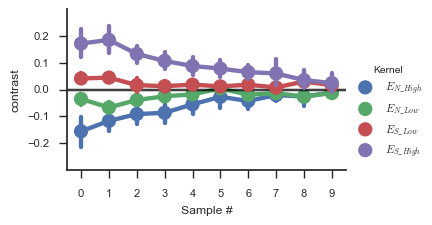

In [214]:
kernel = (dz.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())


#kernel = pd.concat((kernel, kernel_ignore))

condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category', ordered=True)
condition = condition.cat.rename_categories([r'$E_{N\_High}$', r'$E_{N\_Low}$', 
                                             r'$E_{S\_Low}$', r'$E_{S\_High}$'])
kernel['Kernel'] = condition
g = sns.factorplot(x='time', y='contrast', hue='Kernel', 
                   data=kernel, legend=True,
                    size=2.5, 
                   aspect=1.5, font_scale=.8)
g.axes[0,0].axhline(0, color='k', alpha=0.5)
g.axes[0,0].set_yticks([-.2, -0.1, 0, 0.1, .2])
g.axes[0,0].set_xlabel('Sample #')

g.axes[0,0].axhline(0, color='k', alpha=0.5)
savefig('/Users/nwilming/u/conf_analysis/plots/fig1b_kernels_grand_average.pdf')

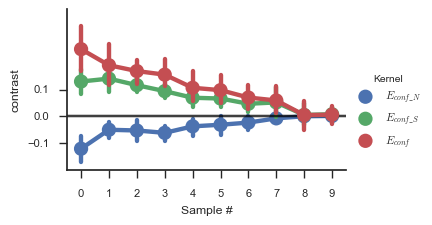

In [400]:
kernel = (dz.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['optidx', 'snum', 'time'])
          .apply(lambda x: x.query('confidence==2').mean()-x.query('confidence==1').mean())
     .reset_index())

df = lambda x: x.query('optidx==1').mean()-x.query('optidx==0').mean()

kernel_diff = (kernel.set_index(['snum', 'time', 'optidx'])
                     .groupby(level=['snum', 'time']).apply(df)).reset_index()
kernel_diff['optidx'] = 3
kd = pd.concat((kernel, kernel_diff))

kd['Kernel'] = (kd.optidx.astype('category', ordered=True)
                    .cat.rename_categories([r'$E_{conf\_N}$', r'$E_{conf\_S}$', r'$E_{conf}$']))
g = sns.factorplot(x='time', y='contrast', hue='Kernel', data=kd, legend=True, alpha=0.75, 
                   size=2.5, 
                   aspect=1.5, font_scale=.8)

g.axes[0,0].axhline(0, color='k', alpha=0.5)
g.axes[0,0].set_yticks([-0.1, 0, 0.1])
g.axes[0,0].set_xlabel('Sample #')
g.axes[0,0].axhline(0, color='k', alpha=0.5)
#g.axes[0,1].axhline(0, color='k', alpha=0.5)
#suptitle('Figure 1 F and E')
savefig('/Users/nwilming/u/conf_analysis/plots/fig1C_confidence_kernels_grand_average.pdf')

0.706396308627
0.000304966441403
0.0239339090295
0.0550634591714
0.201870292243
0.11748546164
0.195959759907
0.195571017547
0.797413629901
0.678412386524


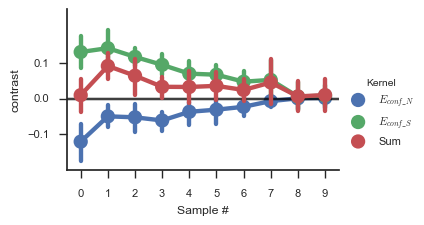

In [402]:
df = lambda x: x.query('optidx==1').mean()+x.query('optidx==0').mean()

kernel_diff = (kernel.set_index(['snum', 'time', 'optidx'])
                     .groupby(level=['snum', 'time']).apply(df)).reset_index()
kernel_diff['optidx'] = 3
kd = pd.concat((kernel, kernel_diff))

kd['Kernel'] = (kd.optidx.astype('category', ordered=True)
                    .cat.rename_categories([r'$E_{conf\_N}$', r'$E_{conf\_S}$', r'Sum']))
                
g = sns.factorplot(x='time', y='contrast', hue='Kernel', data=kd, 
                   legend=True, alpha=0.75, 
                   size=2.5, 
                   aspect=1.5, font_scale=.8)

g.axes[0,0].axhline(0, color='k', alpha=0.5)
g.axes[0,0].set_yticks([-0.1, 0, 0.1])
g.axes[0,0].set_xlabel('Sample #')
g.axes[0,0].axhline(0, color='k', alpha=0.5)

for m, l in kernel_diff.groupby('time'):
    #plot(l.time, l.contrast.values, '-')
    print ttest_1samp(l.contrast, 0)[1]
    #text()

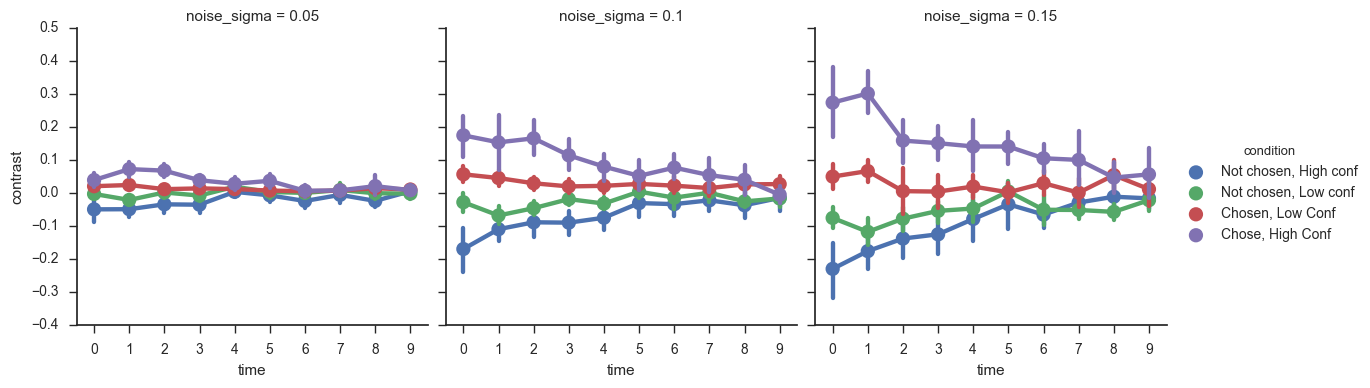

In [197]:
kernel = (dz.groupby(['noise_sigma', 'confidence', 'snum'])
     .apply(lambda x: get_pk(x, contrast_mean=0))
     .groupby(level=['noise_sigma', 'confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())

#kernel_ignore['Fluctuations'] = False
#kernel = pd.concat((kernel, kernel_ignore))

condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category', ordered=True)
condition = condition.cat.rename_categories(['Not chosen, High conf', 'Not chosen, Low conf', 
                                             'Chosen, Low Conf', 'Chose, High Conf '])
kernel['condition'] = condition
g = sns.factorplot(x='time', y='contrast', hue='condition', col='noise_sigma', 
               data=kernel, legend=True)
#g.set(ylim=(-0.055, 0.055))
savefig('/Users/nwilming/u/conf_analysis/plots/kernels_by_variance.pdf')

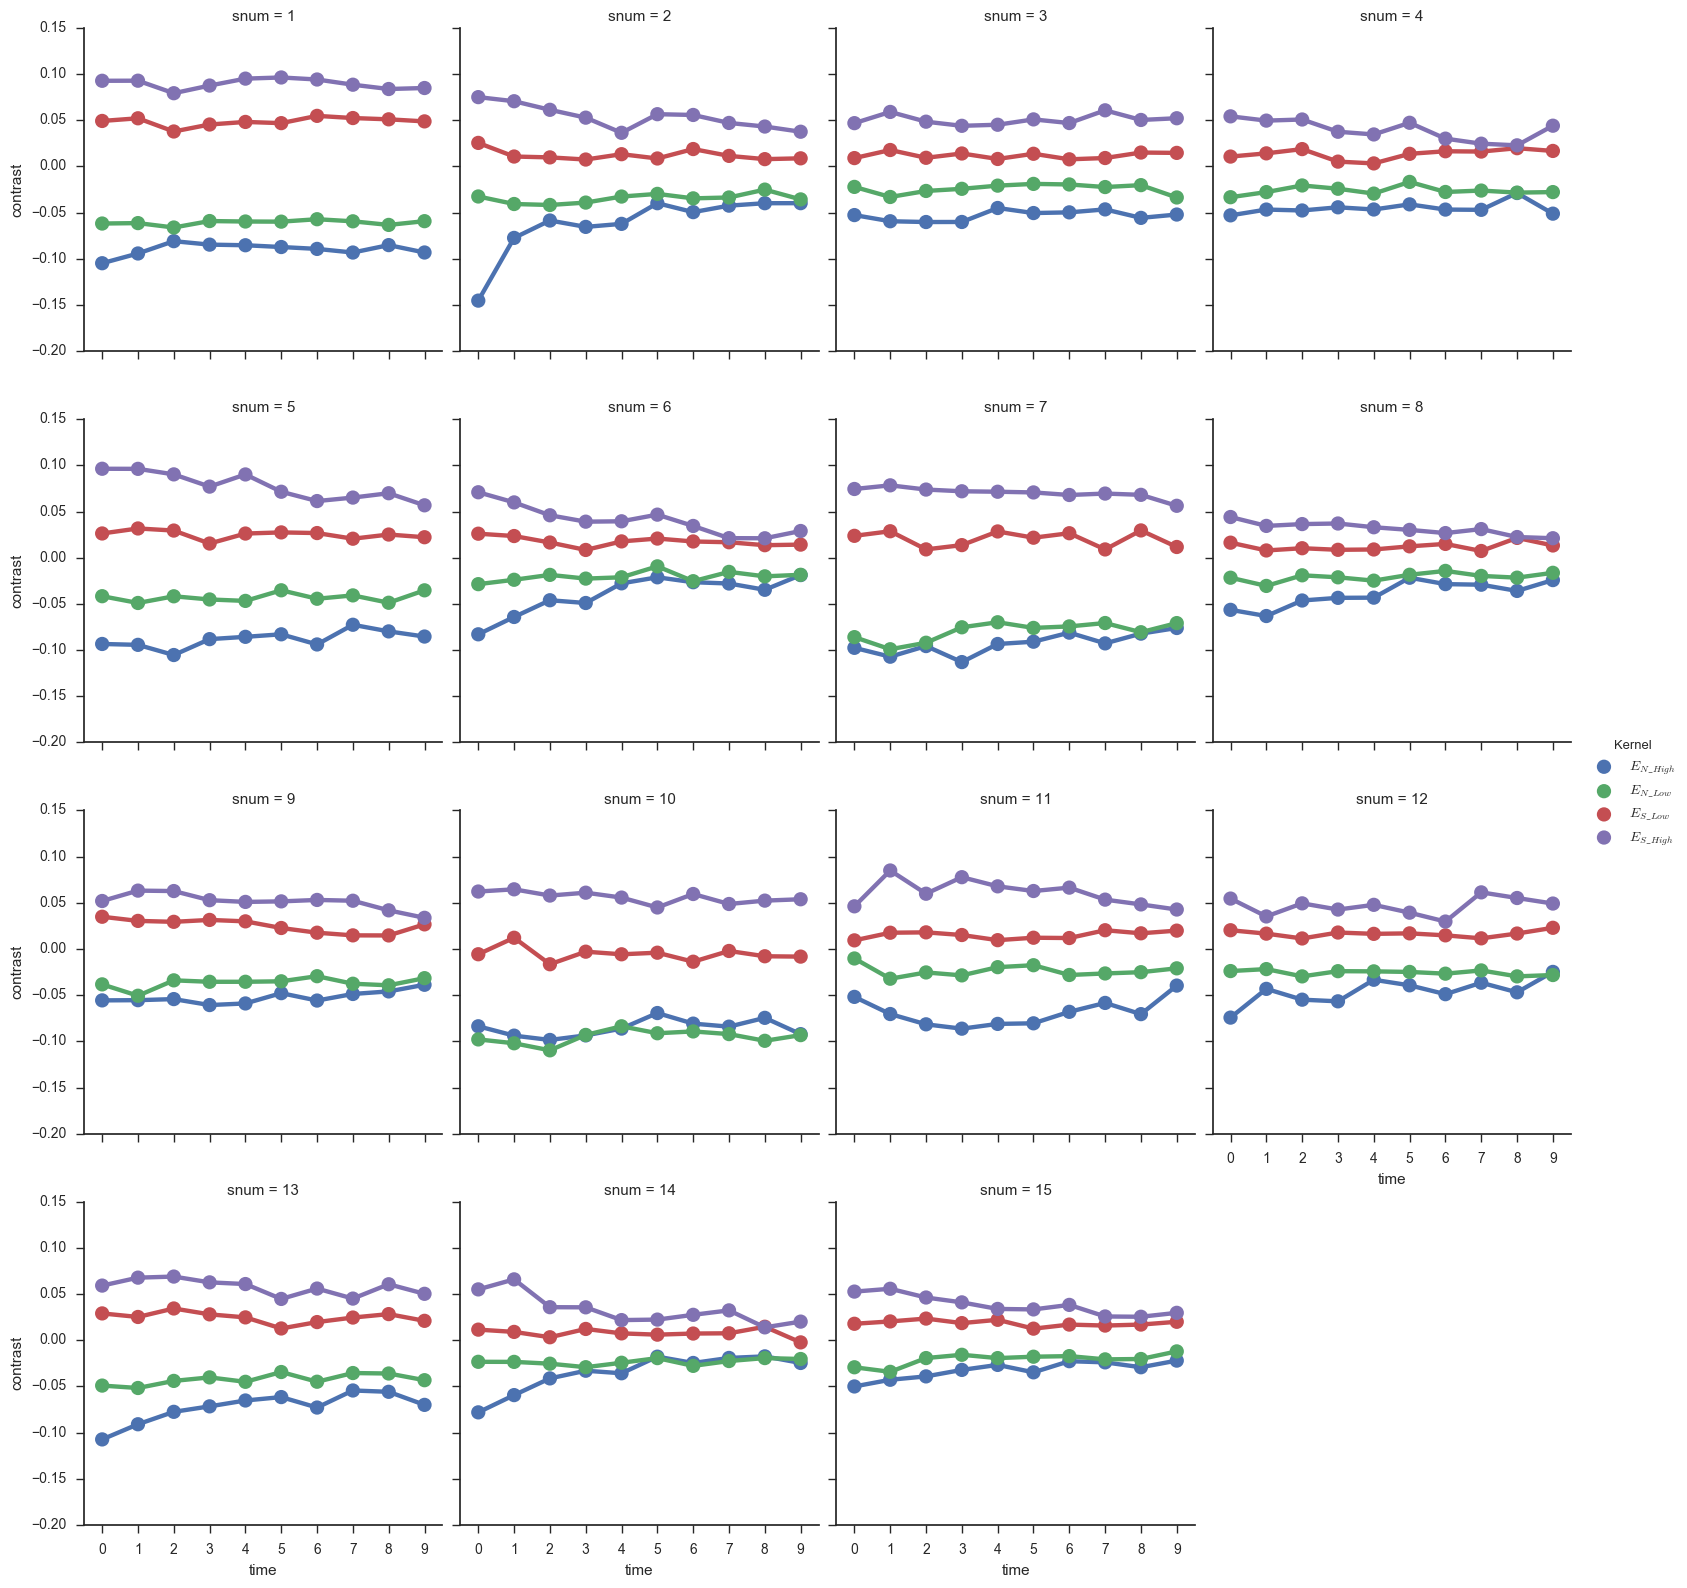

In [13]:
kernel = (data.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, normalize=False, ignore_ref=True))
     .groupby(level=['confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())

condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category', ordered=True)
condition = condition.cat.rename_categories([r'$E_{N\_High}$', r'$E_{N\_Low}$', 
                                             r'$E_{S\_Low}$', r'$E_{S\_High}$'])
kernel['Kernel'] = condition
g = sns.factorplot(x='time', y='contrast', hue='Kernel', 
                   col='snum', data=kernel, legend=True, col_wrap=4)
savefig('/Users/nwilming/u/conf_analysis/plots/subject_kernels.pdf')

__ Fig 1. Psychophysical kernels as a function of time and decision.__ 

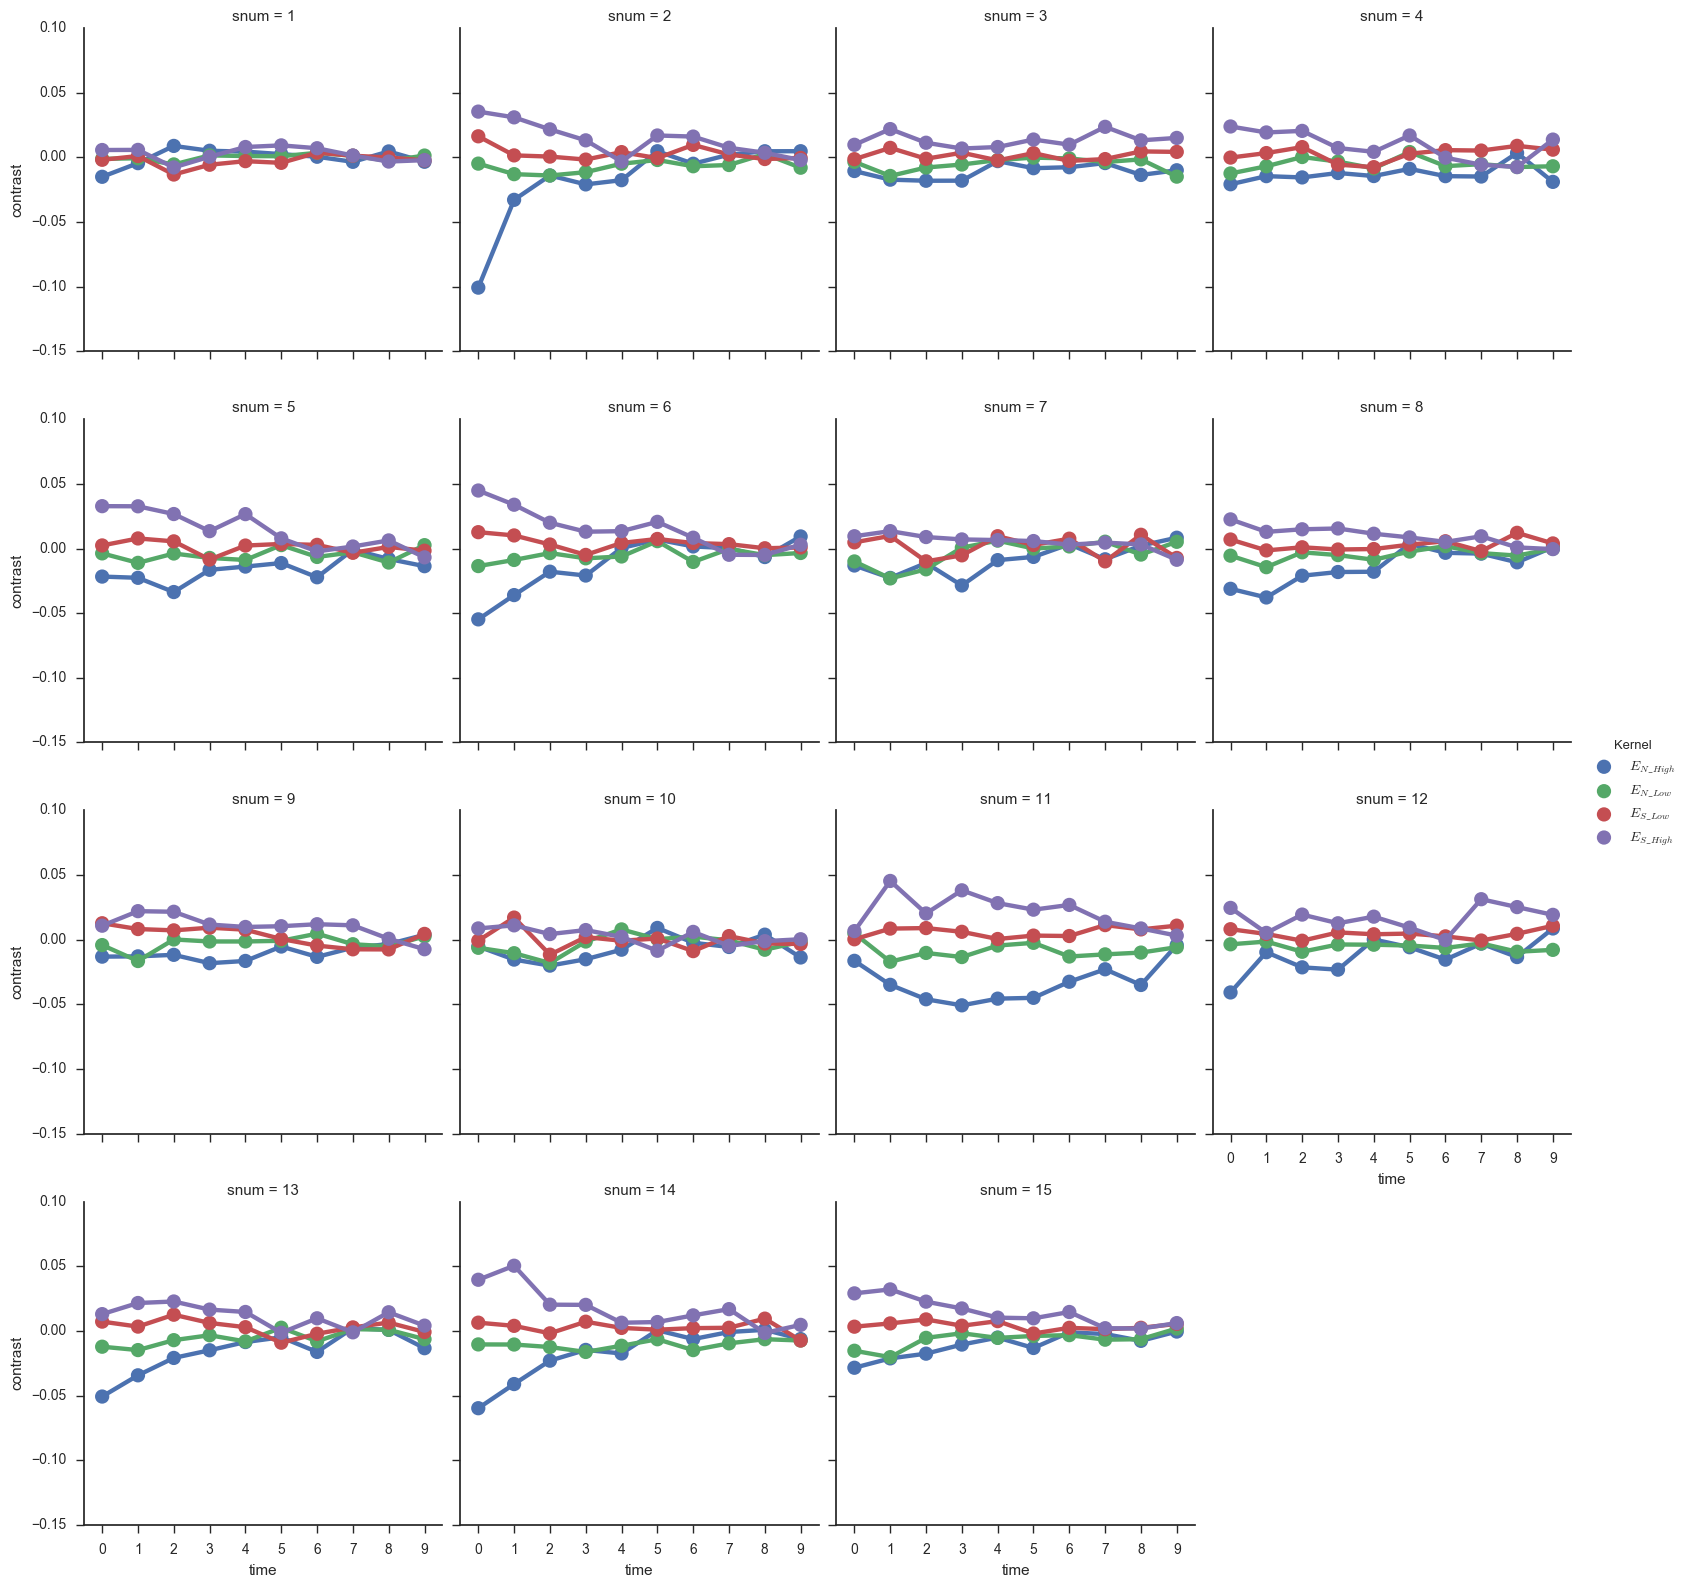

In [14]:
kernel = (data.groupby(['confidence', 'snum'])
     .apply(lambda x: get_pk(x, normalize=True, ignore_ref=True))
     .groupby(level=['confidence', 'optidx', 'snum', 'time']).mean()
     .reset_index())

condition = (kernel.confidence*(kernel.optidx-0.5)).astype('category', ordered=True)
condition = condition.cat.rename_categories([r'$E_{N\_High}$', r'$E_{N\_Low}$', 
                                             r'$E_{S\_Low}$', r'$E_{S\_High}$'])
kernel['Kernel'] = condition
g = sns.factorplot(x='time', y='contrast', hue='Kernel', 
                   col='snum', data=kernel, legend=True, col_wrap=4)
savefig('/Users/nwilming/u/conf_analysis/plots/subject_kernels_fluctuations.pdf')

__Fig 2. Fluctuation kernels.__ Same as before, but this time with mean of trial subtracted.

### Confidence vs. mean contrast

The next plot shows the percentage of high confidence trials as a function of the mean contrast within a trial.

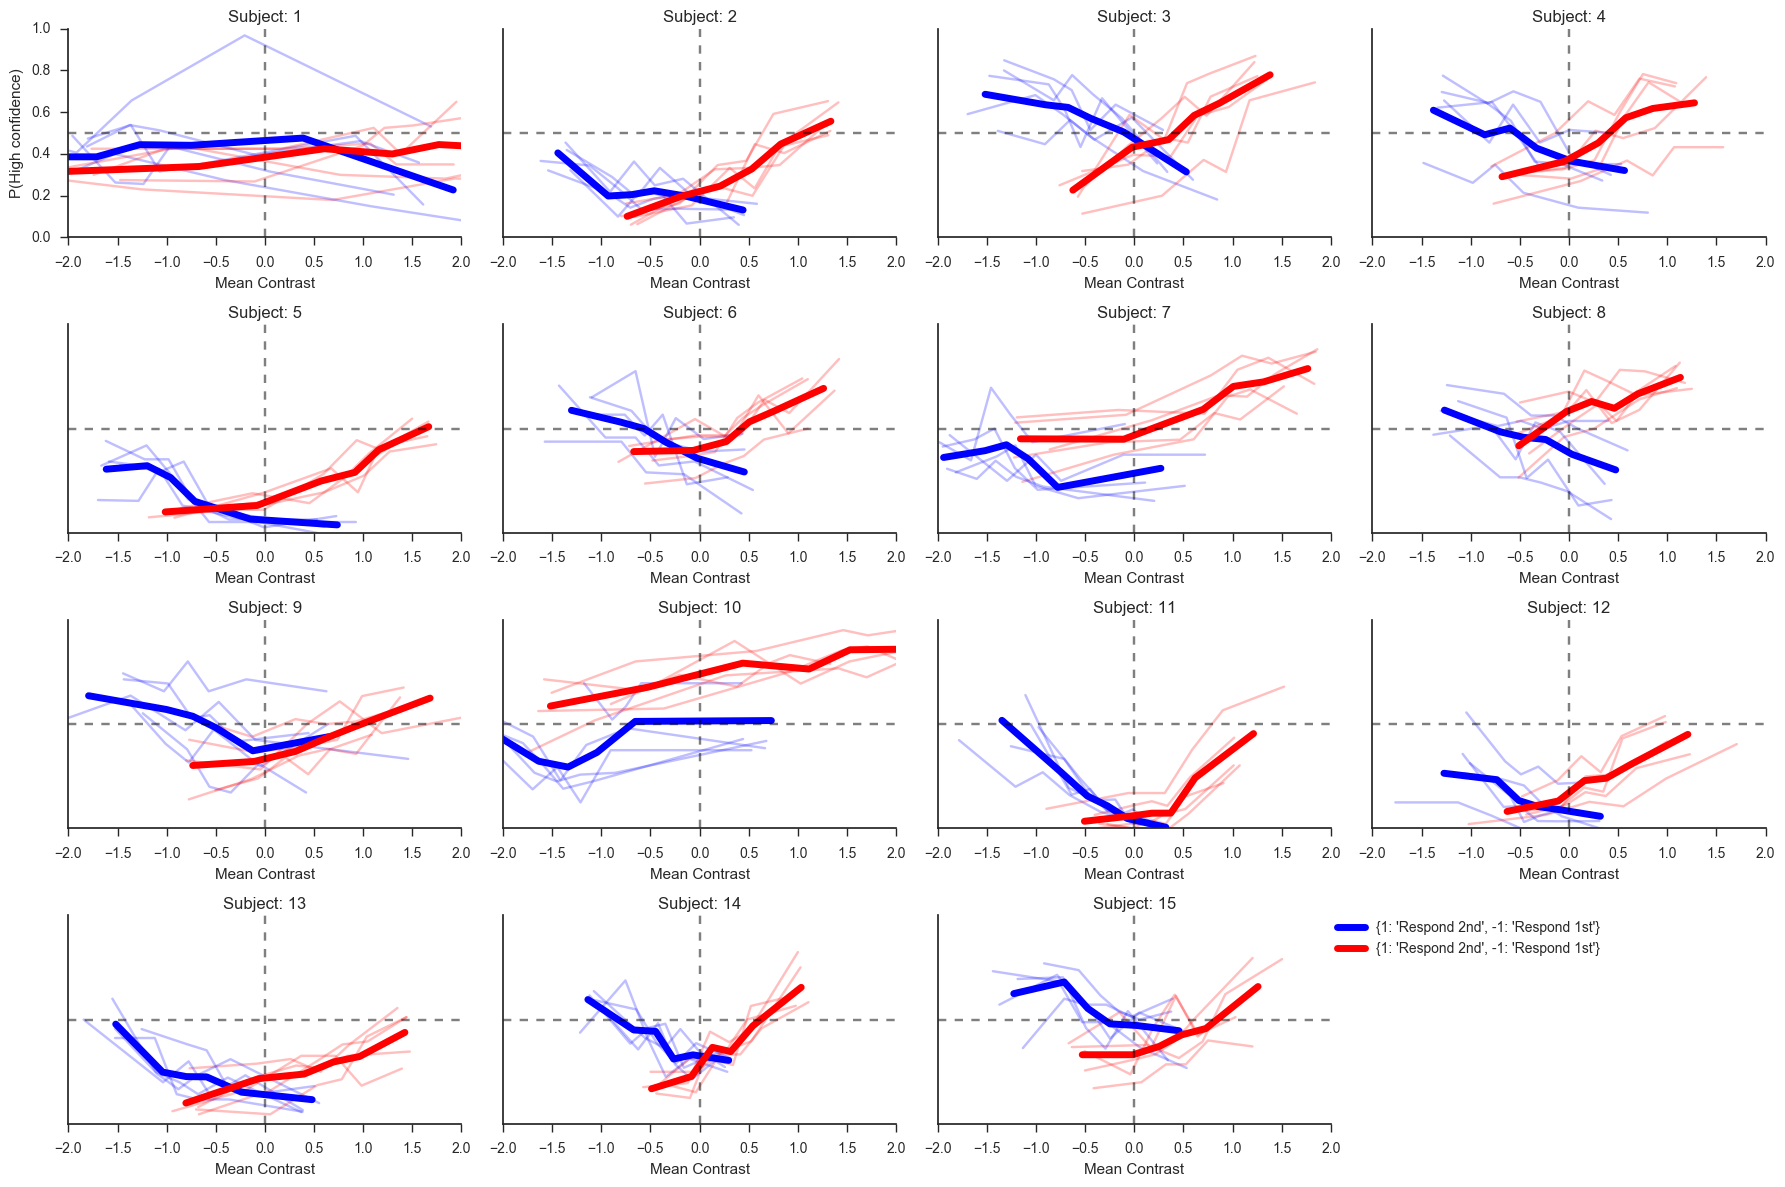

In [15]:
figure(figsize=(18, 12))
for c, sub in dz.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for (block, response), s in sub.groupby(['day', 'response']):
        centers, frac = empirical.asfuncof(s.mc.values, s.confidence.values==2, bins=linspace(1,99, 7))
        plot(centers, frac, {-1:'b-', 1:'r-'}[response], alpha=0.25)
    for response, s in sub.groupby('response'):
        centers, frac = empirical.asfuncof(s.mc.values, s.confidence.values==2, bins=linspace(1,99, 7))
        plot(centers, frac, {-1:'b-', 1:'r-'}[response], alpha=1, lw=5, label={-1:'Respond 1st', 1:'Respond 2nd'})

    sns.despine()
    ylim([0, 1])
    xlim([-2, 2])
    if c>1:
        yticks([])
    xlabel('Mean Contrast')
    if c==1:
        ylabel('P(High confidence)')
    plot(xlim(), [0.5, 0.5], 'k--', alpha=0.5)  
    plot([0., 0.],ylim(), 'k--', alpha=0.5)  
    title('Subject: %i'%c)
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/confidence_vs_contrast.pdf')

Comparison to Sanders et al. Neuron 2016 paper
----------------------------------------------

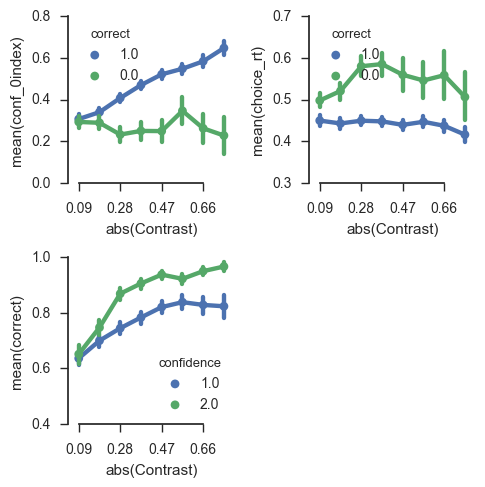

In [16]:
figure(figsize=(5, 5))
def histify(x, bins, field, name, labels=None):
    if labels is None:
        labels = around([(low + (high-low)/2.) for low, high in zip(bins[:-1], bins[1:])], 2)
    bins = pd.cut(x[field], bins, labels=labels)
    x[name] = bins
    return x

dz.loc[:, 'conf_0index'] = dz.confidence-1
dz.loc[:, 'absmc'] = (dz.mc)
absmcut = linspace(0, 1.5, 9) #prctile(dz.query('snum>1').absmc, linspace(5, 95, 7))
mcut = linspace(-1.5, 1.5, 12) #prctile(dz.query('snum>1').absmc, linspace(5, 95, 7))

dz = histify(dz, mcut, 'mc', 'mccut')
dz = histify(dz, absmcut, 'absmc', 'abs(Contrast)')
subplot(2,2,1)
sns.pointplot(x='abs(Contrast)', y='conf_0index', unit='snum', 
               data=dz, hue='correct', markers='.')
pyplot.locator_params(nbins=4)
subplot(2,2,2)
sns.pointplot(x='abs(Contrast)', y='choice_rt', unit='snum', 
               data=dz, hue='correct', markers='.')
pyplot.locator_params(nbins=4)
subplot(2,2,3)
sns.pointplot(x='abs(Contrast)', y='correct', unit='snum', 
               data=dz, hue='confidence', markers='.')
pyplot.locator_params(nbins=4)

sns.despine(trim=True)
tight_layout()

__ Fig 3. Confidence as a function of mean (sample) contrast in a trial.__ The y-axis shows the proportion of high confidence judgements. X-axis shows the mean contrast of a trial. Blue lines decisions for the 1st grating, red lines for the 2nd grating. Thick lines are pooled across all sessions, thin lines are individual sessions.  

Confidence and Accuracy vs. Variance
----------------------------------

The next upcoming plots are meant as a point of comparison with the Zylberberg et al. variance misperception paper.

   1. Accuracy and fraction of high confidence ratings vs. Contrast and Variance. This should map to figure 1b and h. I guess the crucial comparison is to evaluate whether confidence a contrast 0.5 scales with variance. Also check if performance at contrast=0.5 is chance.
 
    
The next plot shows the fraction of high confidence reports as a function of contrast in a trial.

In [219]:
data['conf_0index'] = data.confidence-1
dz['conf_0index'] = dz.confidence-1

def pcut(x, bins, name):
    bins_left = prctile(x.mc[x.mc<=0.5], bins)
    bins_right = prctile(x.mc[x.mc>0.5], bins)
    bins = concatenate((bins_left, bins_right[1:]))
    labels = arange(len(bins)-1)
    bins = pd.cut(x.mc, bins, labels=labels-labels[-1]/2.)
    x[name] = bins
    return x


def qcut(x, bins, name):
    labels = around([(low + (high-low)/2.) for low, high in zip(bins[:-1], bins[1:])], 2)
    bins = pd.cut(x.mc, bins, labels=labels)
    x[name] = bins
    return x

def rvsv(data, bins, values, cut=pcut):
        return (data.groupby('snum')
                     .apply(lambda x: cut(x, bins, 'rankcon'))
                     .pivot_table(values=values, index='rankcon', columns='snum'))
        
def resp_vs_variance(data, bins, values='conf_0index', cut=pcut):
    r1 = rvsv(data, bins, values, cut)
    centers = array(r1.index.values)
    _ = plot(centers, nanmean(r1.values, 1), lw=2.5, alpha=1)

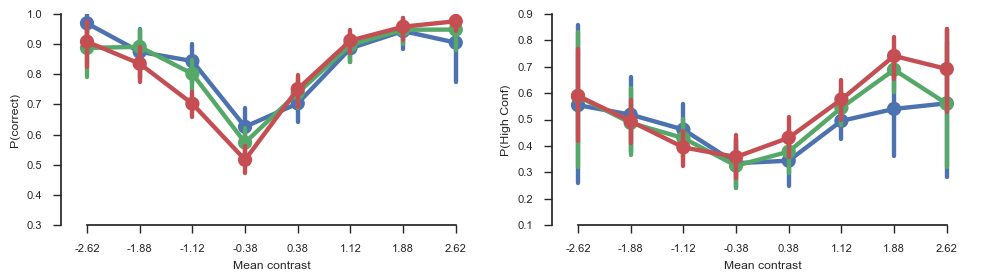

In [255]:
dlin = (dz.groupby(['snum'])
         .apply(lambda x: qcut(x, linspace(-3,3,9), 'lincon'))
         .groupby(['lincon', 'snum', 'noise_sigma'])
         .mean()
         .reset_index())

figure(figsize=(10, 3))
subplot(1,2,1)
sns.pointplot(x='lincon', y='correct', hue='noise_sigma', ci=95, data=dlin)
ylabel('P(correct)')
xlabel('Mean contrast')
legend('')
ylim([0.3, 1])
subplot(1,2,2)
sns.pointplot(x='lincon', y='conf_0index', hue='noise_sigma', ci=95, data=dlin)
ylabel('P(High Conf)')
xlabel('Mean contrast')
legend('')
ylim([0.1, 0.9])

'''
ptiles = linspace(5, 95, 5)
d = (dz.groupby(['snum'])
         .apply(lambda x: pcut(x, ptiles, 'rankcon'))
         .groupby(['rankcon', 'snum', 'noise_sigma'])
         .mean()
         .reset_index())

subplot(2,2,3)
sns.pointplot(x='rankcon', y='correct', hue='noise_sigma', ci=95, data=d)
axvline(3.5, color='k', alpha=0.5)
ylabel('P(correct)')
xlabel('Contrast Rank')
legend('')
ylim([0.3, 1])
subplot(2,2,4)
sns.pointplot(x='rankcon', y='conf_0index', hue='noise_sigma', ci=95, data=d)
axvline(3.5, color='k', alpha=0.5)
ylabel('P(High Conf)')
xlabel('Contrast Rank')
ylim([0.1, 0.9])
'''
sns.despine(trim=True)
tight_layout()

savefig('/Users/nwilming/u/conf_analysis/plots/fig2_mean_confidence_accuracy_vs_contrast.pdf')

In [308]:
#dlin = (dz.groupby(['snum'])
#         .apply(lambda x: qcut(x, linspace(-3,3,9), 'lincon'))
#         .groupby(['lincon', 'snum', 'noise_sigma'])
#         .mean()
#         .reset_index())
c1 = []
c2 = []
for s, sub in dlin.groupby(['snum', 'lincon']):
    corr = pd.pivot_table(sub.query('lincon>0'), 
                      index='lincon', columns='snum', values='correct',
                      aggfunc=nanmean)
    conf = pd.pivot_table(sub.query('lincon>0'), 
                      index='lincon', columns='snum', values='conf_0index',
                      aggfunc=nanmean)
    c1.append(corrcoef(conf.values.ravel(), corr.values.ravel())[0,1])
    corr = pd.pivot_table(sub.query('lincon<0'), 
                      index='lincon', columns='snum', values='correct',
                      aggfunc=nanmean)
    conf = pd.pivot_table(sub.query('lincon<0'), 
                      index='lincon', columns='snum', values='conf_0index', 
                      aggfunc=nanmean)
    c2.append(corrcoef(conf.values.ravel(), corr.values.ravel())[0,1])

/Users/nwilming/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/nwilming/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2079: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


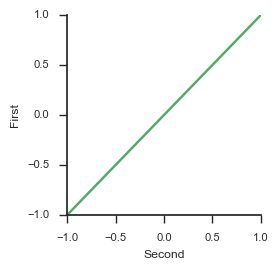

In [309]:
figure(figsize=(2.5, 2.5))
plot(c1, c2, '.')
ylabel('First')
xlabel('Second')
plot([-1, 1], [-1, 1])
sns.despine()


__ Fig 4__

## d' and criterion as function of evidence and noise

To compute d' and criterion I conceptualize the task as asking 'Is the contrast of the second stimulus above the reference?'. This yields to the following definitions:


|       | Above | Below |
| ----- |:-----:| -----:|
| **Above** | Hit   | FA    |
| **Below** | Miss  | CR    |

$$d' = z(Hit) - z(FA)$$
$$c = -\frac{1}{2}(z(Hit) + z(FA))$$


In [266]:
from scipy.stats import linregress
from scipy.stats import ttest_1samp

-0.336190238821


Ttest_1sampResult(statistic=-2.8212684248247673, pvalue=0.013598708535794412)

Mean criterion slope: -0.00219586953155
p: -0.05202
Mean d' slope: 0.173192605466
p: 0.80043
Mean hit vs. fa slope: 0.64992617248
p: 7.192e-07


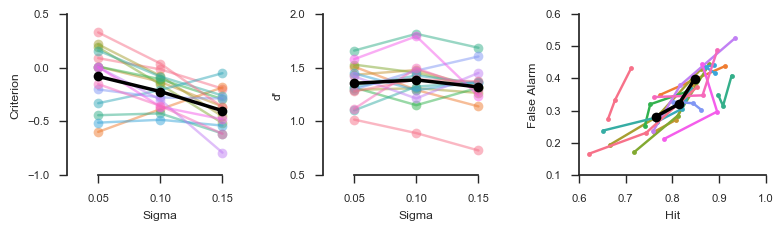

In [275]:

figure(figsize=(8,2.5))
with sns.color_palette("husl", 14):
    subplot(1,3,1)
    t1 =(data.groupby(['snum', 'noise_sigma'])
             .apply(empirical.crit).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    slopes = []
    for k in t1.values.T:
        slopes.append(linregress(k, [0.01, 0.10, 0.15])[1])
    print 'Mean criterion slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[0], 5)
    pyplot.locator_params(nbins=4)
    ylabel('Criterion')
    xlabel('Sigma')
    xlim([0.025, 0.175])
    subplot(1,3,2)
    t1 =(data.groupby(['snum', 'noise_sigma'])
             .apply(empirical.dp).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    slopes = []
    for k in t1.values.T:
        slopes.append(linregress(k, [0.01, 0.10, 0.15])[1])
    print 'Mean d\' slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[0], 5)
    
    plot(t1.index.values, t1.values, 'o-', alpha=0.5)
    plot(t1.index.values, t1.values.mean(1), 'ko-', lw=2.5)
    pyplot.locator_params(nbins=4)
    ylabel(r"d'")
    xlabel('Sigma')
    xlim([0.025, 0.175])
    subplot(1,3,3)
    hit =(data.groupby(['snum', 'noise_sigma'])
             .apply(lambda x: empirical.tbl(x)[0]).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    fa =(data.groupby(['snum', 'noise_sigma'])
             .apply(lambda x: empirical.tbl(x)[1]).reset_index()
             .pivot_table(index='noise_sigma', columns='snum'))
    slopes = []
    for k, c in zip(hit.values.T, fa.values.T):
        slopes.append(linregress(c, k)[1])
    print 'Mean hit vs. fa slope:', mean(slopes)
    print 'p:',  round(ttest_1samp(slopes, 0)[1], 10)
    
    plot(hit, fa, '.-')
    plot(hit.mean(1), fa.mean(1), 'ko-', lw=2.5)
    xlabel('Hit')
    ylabel('False Alarm')
    pyplot.locator_params(axis='y', nbins=5)
    pyplot.locator_params(axis='x', nbins=5)
    sns.despine(trim=True)
    tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/fig3_sdt_parameters.pdf')

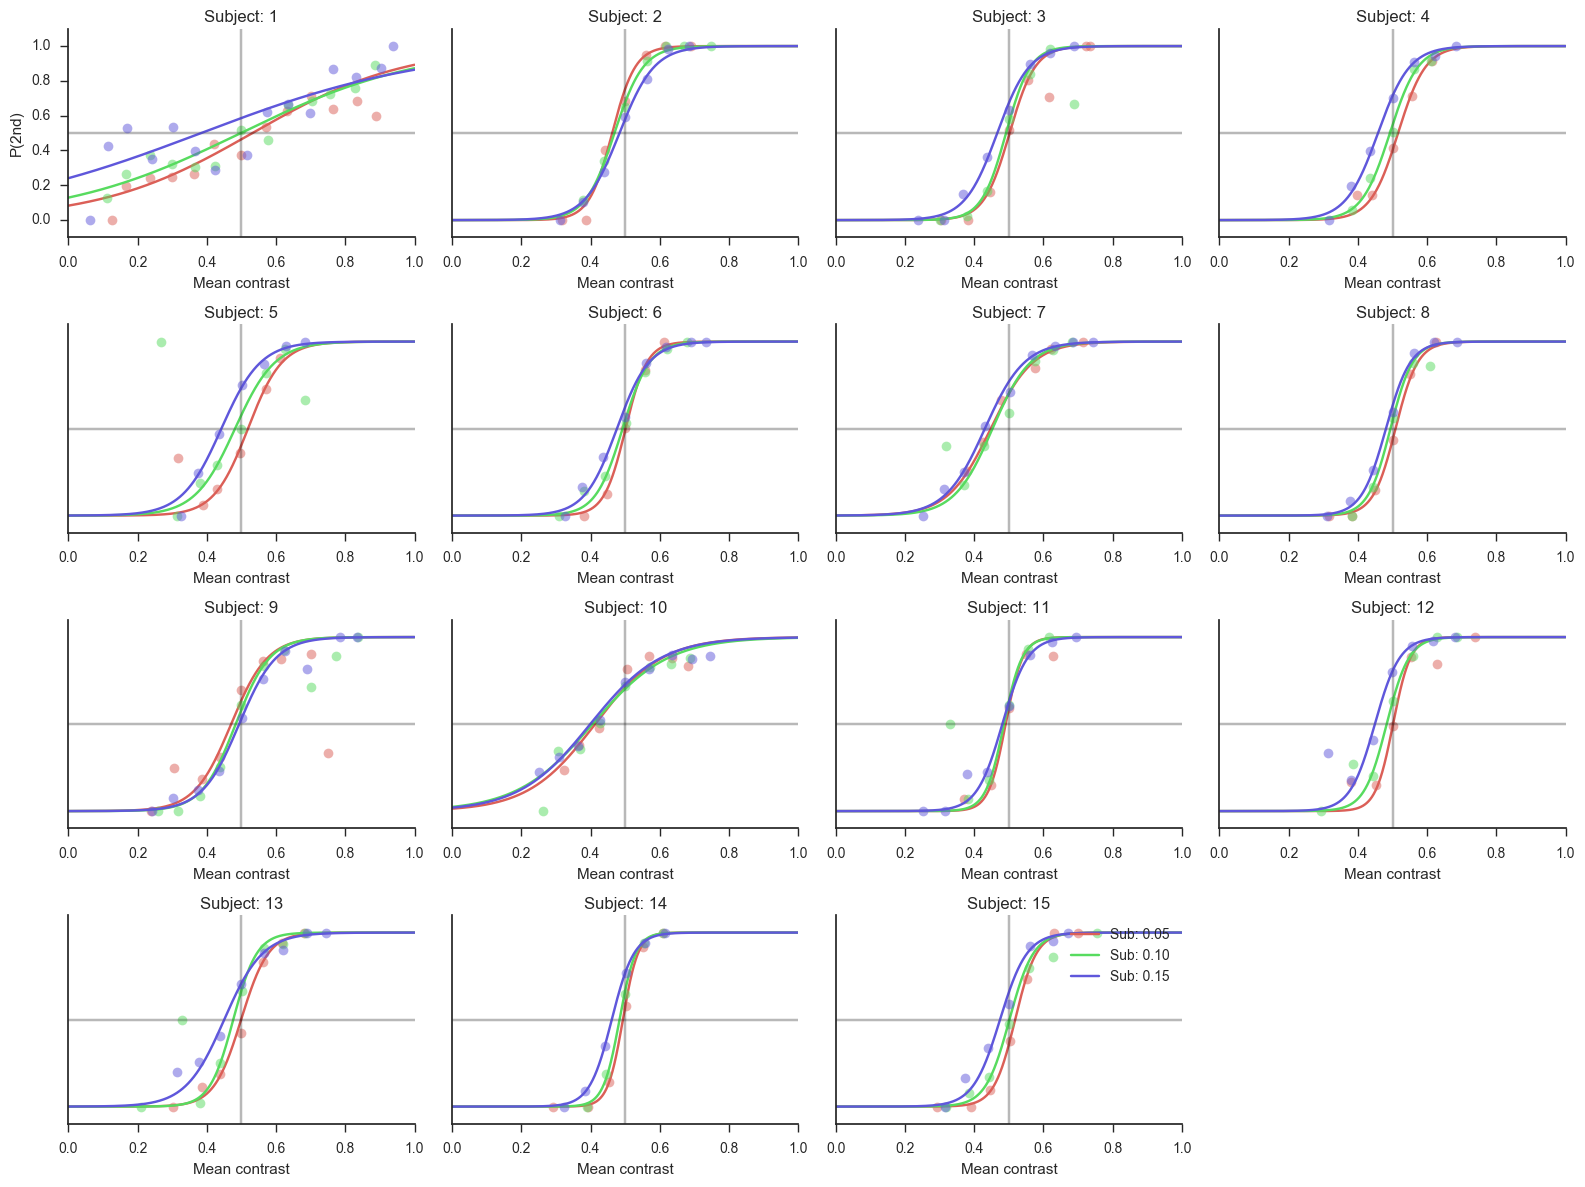

In [20]:
import patsy
import pandas as pd
figure(figsize=(16,12))
x = linspace(0, 1, 1000)
nti = {0.05:0, 0.1:1, 0.15:2}
colors = sns.color_palette("hls", 3)
for (snum, day), sub in data.groupby(['snum', 'noise_sigma']):
    subplot(4,4, snum)
    log_res, results = empirical.fit_logistic(sub, 'R ~ mc + 1', summary=False)
    X = vstack([ones(x.shape), x])
    plot(x, results.predict(X.T), label='Sub: %1.2f'%day, color=colors[nti[day]])

    for c, d in sub.groupby(pd.cut(sub.mc, linspace(0, 1, 16))):
        if len(d) == 0:
            continue
        plot(d.mc.mean(), d.R.sum()/float(len(d)), 'o', color=colors[nti[day]], alpha=0.5)
    ylim([-0.1, 1.1])
    sns.despine()
    ylabel('P(2nd)')
    xlabel('Mean contrast')
    #legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
    plot(xlim(), [0.5, 0.5], 'k', alpha=0.1)
    plot([.5, .5], ylim(), 'k', alpha=0.1)
    if snum>1:
        ylabel('')
        yticks([])
    title('Subject: %i'%snum)

legend()
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/response_curves_var.pdf')

P(14 | binom(n=14, p=0.5)): 0.0


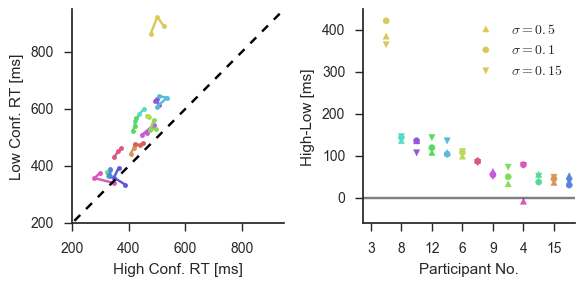

In [21]:
figure(figsize=(6,3))
subplot(1,2,1)
colors = array(sns.color_palette("hls", 15))
drt = ((data.groupby(['snum', 'noise_sigma', 'confidence'])
           .choice_rt.mean()*1000).reset_index())
high = drt.query('confidence==2').pivot_table(index='snum', columns='noise_sigma', values='choice_rt')
low = drt.query('confidence==1').pivot_table(index='snum', columns='noise_sigma', values='choice_rt')
idx = argsort((low.mean(1)-high.mean(1)).values)[::-1]
delta_rt = (low-high).values

for i in idx+1:
    plot(high.loc[i,:], low.loc[i,:], '.-', color=colors[i-1])
plot([0, 1000], [0,1000], 'k--')
pyplot.locator_params(nbins=4)
ylim([200, 950])
xlim([200, 950])
ylabel(r'Low Conf. RT [ms]')
xlabel(r'High Conf. RT [ms]')
subplot(1,2,2)

scatter(arange(len(idx))+1, delta_rt[idx,0], c=colors[idx], marker='^', label=r'$\sigma=0.5$', edgecolors='face')
scatter(arange(len(idx))+1, delta_rt[idx,1], c=colors[idx], marker='o', label=r'$\sigma=0.1$', edgecolors='face')
scatter(arange(len(idx))+1, delta_rt[idx,2], c=colors[idx], marker='v', label=r'$\sigma=0.15$', edgecolors='face')

legend()
xticks(xticks()[0], idx+1)
xlim([-0.5, 13.4])
ylim([-60, 450])
plot(xlim(), [0, 0], 'k', alpha=0.5)
xlabel(r'Participant No.')
ylabel(r'High-Low [ms]')
sns.despine()
tight_layout()

from scipy.stats import binom
cnt = sum(delta_rt.mean(1) > 0)
print 'P(%i | binom(n=14, p=0.5)):'%cnt, 1-binom.cdf(cnt, 14, 0.5 )
savefig('/Users/nwilming/u/conf_analysis/plots/rt_var_and_conf.pdf')

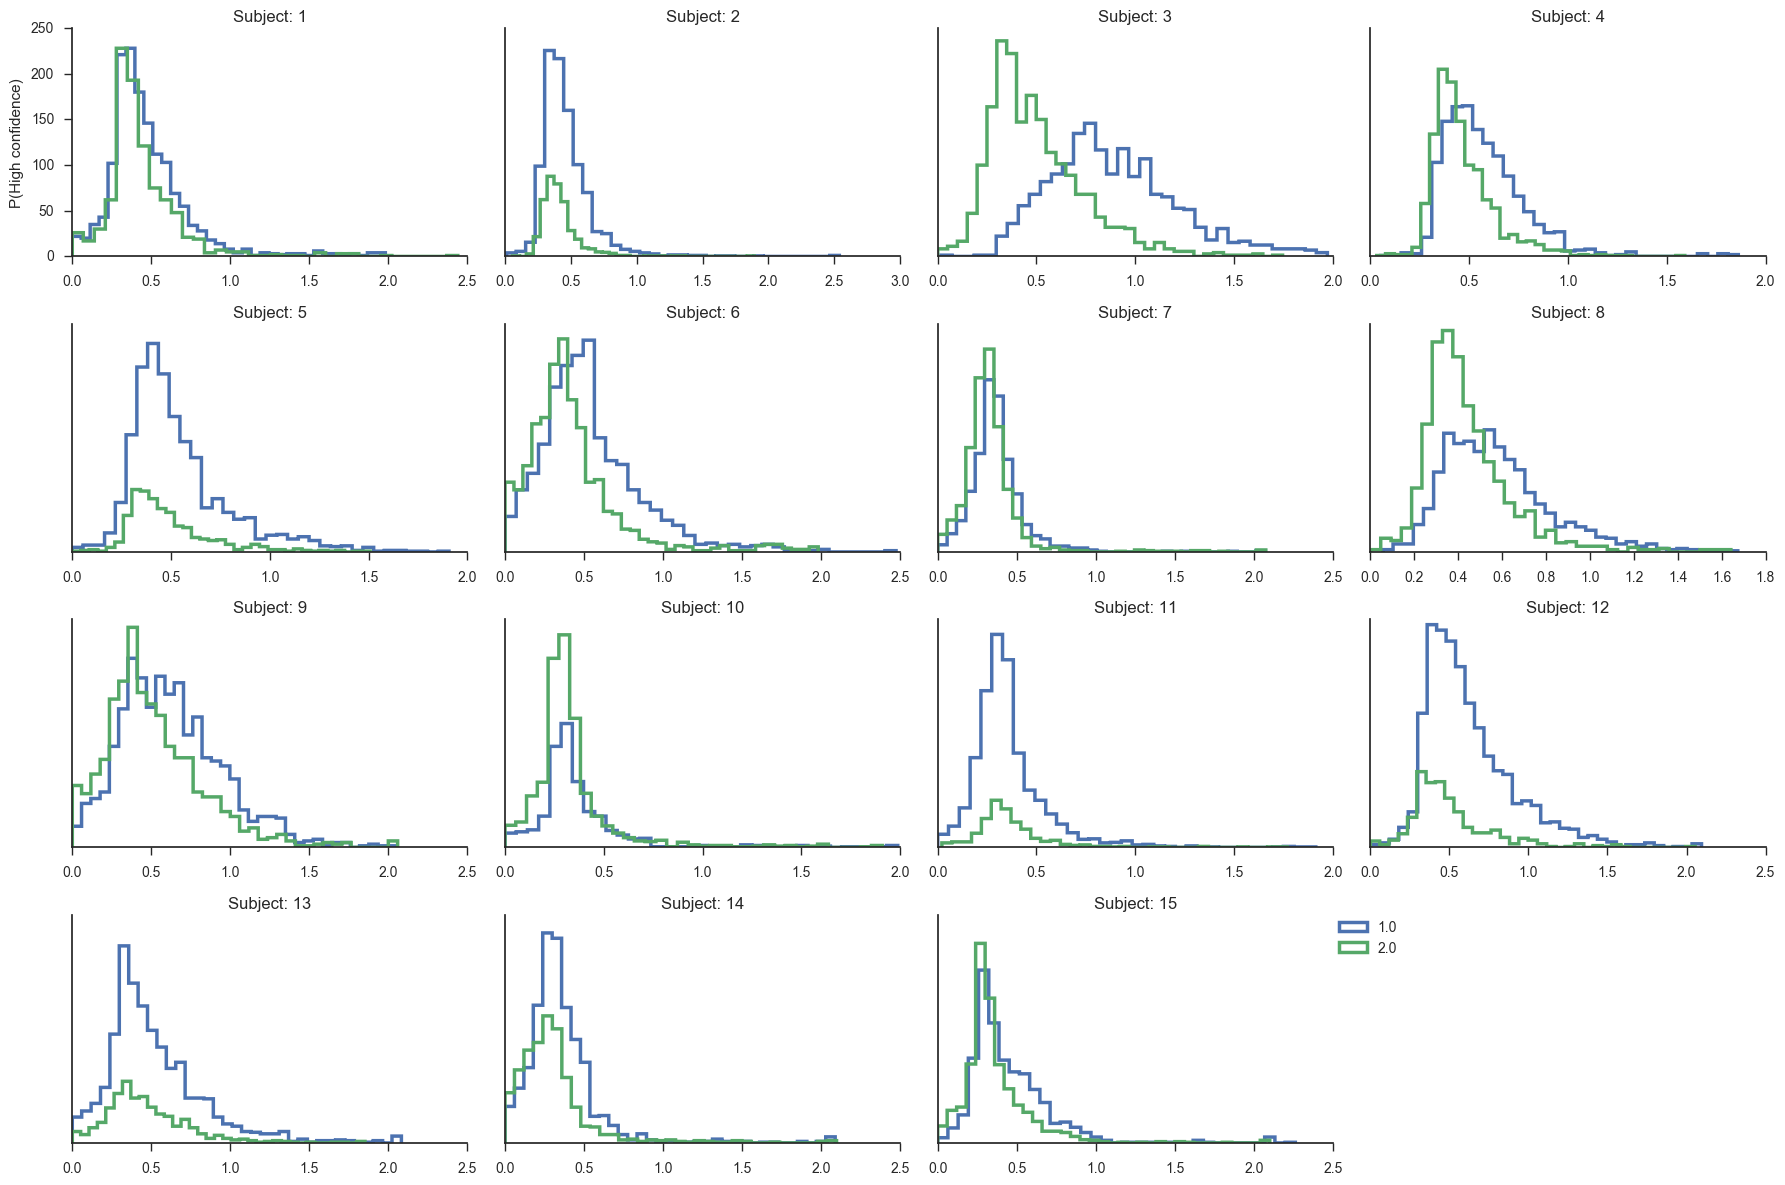

In [22]:
figure(figsize=(18, 12))
for c, sub in data.groupby('snum'):
    subplot(4,4,c)
    cnt = 0
    for d, dec in sub.groupby(['confidence']):
        rts = dec.choice_rt[~isnan(dec.choice_rt)]
    
        hist(rts.values, 35, histtype='step', label=str(d), lw=2.5)
    if c>1:
        yticks([])
    if c==1:
        ylabel('P(High confidence)')

    title('Subject: %i'%c)
sns.despine()
legend(bbox_to_anchor=(1.001, 1), loc=2, borderaxespad=0.)
tight_layout()


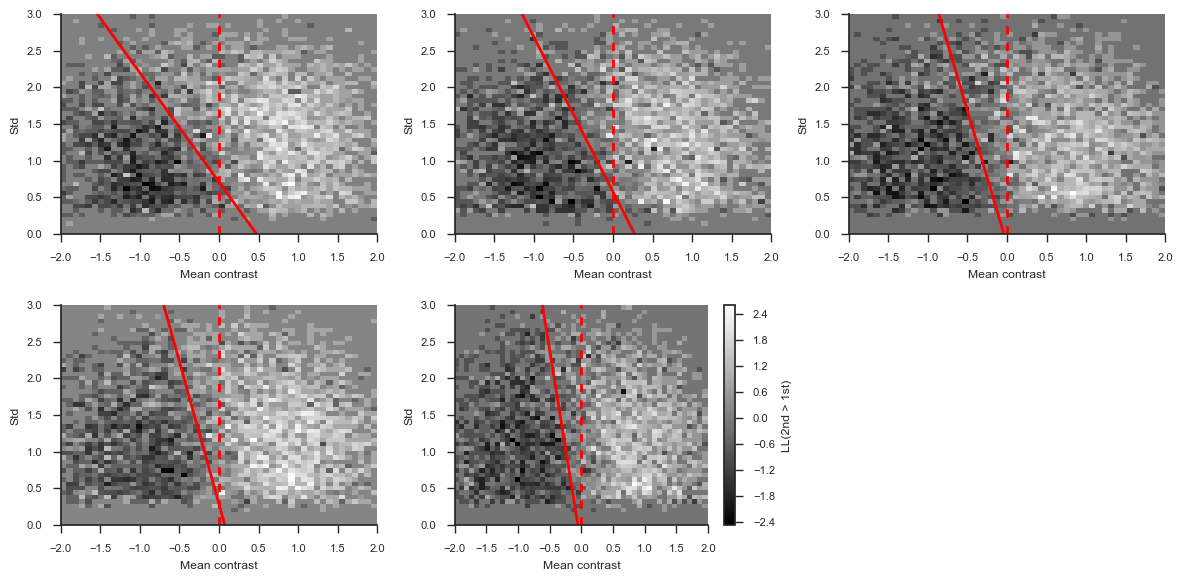

In [371]:
figure(figsize=(12, 6))
gray()
stddf = []
for i, ( noise, nd) in enumerate(dz.groupby('session_num')):
    subplot(2, 3, i+1)    
    log_res, results = empirical.fit_logistic(nd, 'R ~ mc + stdc', summary=False)
    _= empirical.plot_model(nd, results, bins=[linspace(0, 3.,51), linspace(-2,2,51)])
    for j, sub in nd.groupby('snum'):
        log_res, results = empirical.fit_logistic(sub, 'R ~ mc + stdc', summary=False)
        stddf.append({'session':i, 'beta':results.params['stdc'], 'snum':j, 'mcb':results.params['mc']})
    sns.despine()
    xlabel('Mean contrast')
    ylabel('Std')
    
colorbar(label='LL(2nd > 1st)')
tight_layout()
savefig('/Users/nwilming/u/conf_analysis/plots/fig4_contrast_vs_std.png')

0.138866346198


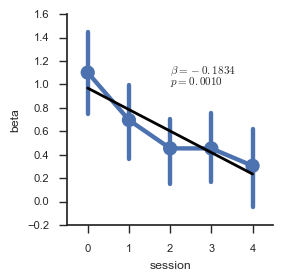

In [375]:
df_slope = pd.DataFrame(stddf)
sns.factorplot(x='session', y='beta', data=df_slope, size=3)
s, i, r, p, se = linregress(
    df_slope.session.values, 
    df_slope.beta.values)

print r**2
x = array([0, 4])
plot(x, x*s+i, 'k', lw=2)
text(2, 1, r'$p=%0.4f$'%p, fontsize=8)
text(2, 1.1, r'$\beta=%0.4f$'%s, fontsize=8)
savefig('/Users/nwilming/u/conf_analysis/plots/fig5_slopes.png')

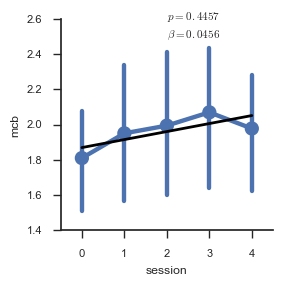

In [374]:
df_slope = pd.DataFrame(stddf)
sns.factorplot(x='session', y='mcb', data=df_slope, size=3)
s, i, r, p, se = linregress(
    df_slope.session.values, 
    df_slope.mcb.values)

x = array([0, 4])
plot(x, x*s+i, 'k', lw=2)
text(2, 2.6, r'$p=%0.4f$'%p, fontsize=8)
text(2, 2.5, r'$\beta=%0.4f$'%s, fontsize=8)
savefig('/Users/nwilming/u/conf_analysis/plots/fig5_slopes_mc.png')

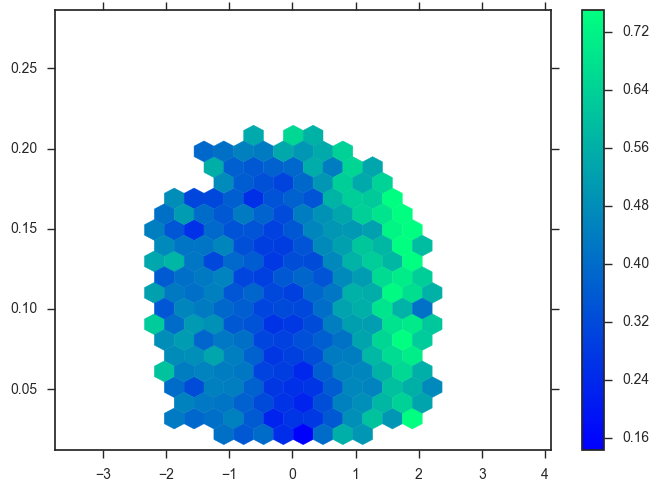

In [24]:
hexbin(dz.mc.values, data.stdc.values, 
       dz.confidence.values-1, mincnt=20, cmap=winter(), vmax=0.75,
       gridsize=25)

colorbar()

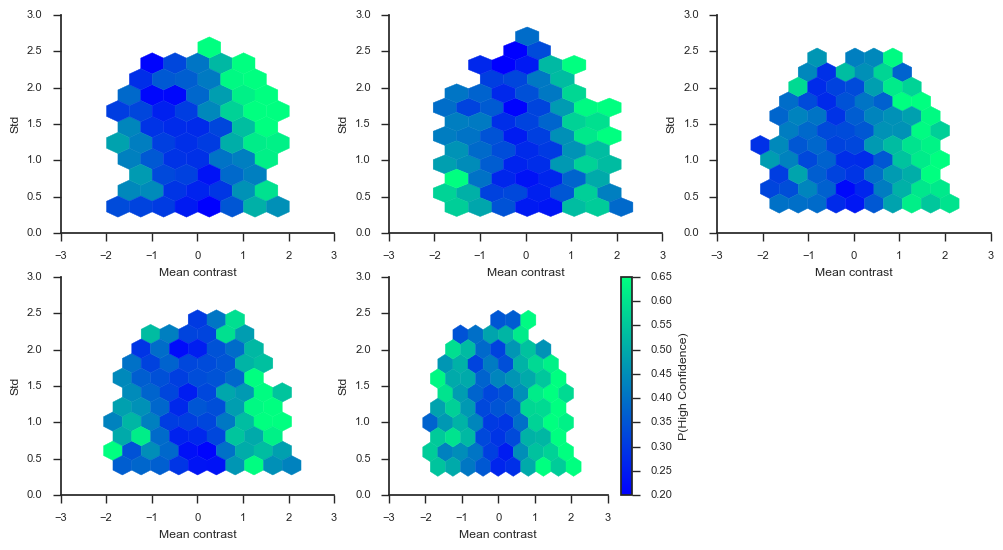

In [376]:
figure(figsize=(12, 6))
for i, ( noise, nd) in enumerate(dz.groupby('session_num')):
    subplot(2,3,i+1)
    hexbin(nd.mc.values, nd.stdc.values, 
           nd.confidence.values-1, mincnt=20, cmap=winter(), vmin=0.2, vmax=0.65,
           gridsize=15)
    ylim([0, 3])
    xlim([-3, 3])
    xlabel('Mean contrast')
    ylabel('Std')
sns.despine()

colorbar(label='P(High Confidence)')

savefig('/Users/nwilming/u/conf_analysis/plots/fig7_contrast_vs_std_conf.png')

In [26]:
log_res, results = empirical.fit_logistic(dz, '''
R ~ C(snum) + (mc  + stdc + mc*stdc + C(confidence) + C(side) + C(expand))
''')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      R   No. Observations:                36986
Model:                            GLM   Df Residuals:                    36965
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -19481.
Date:                 Mi, 06 Jul 2016   Deviance:                       38963.
Time:                        10:35:40   Pearson chi2:                 3.90e+04
No. Iterations:                     7                                         
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               -0.8685      0.066    -13.122      0.000        -0.998    -0.739
C(snum)[T.2]          

------------------------------

Various other things: Block/Time resolved analysis etc.
=================================================

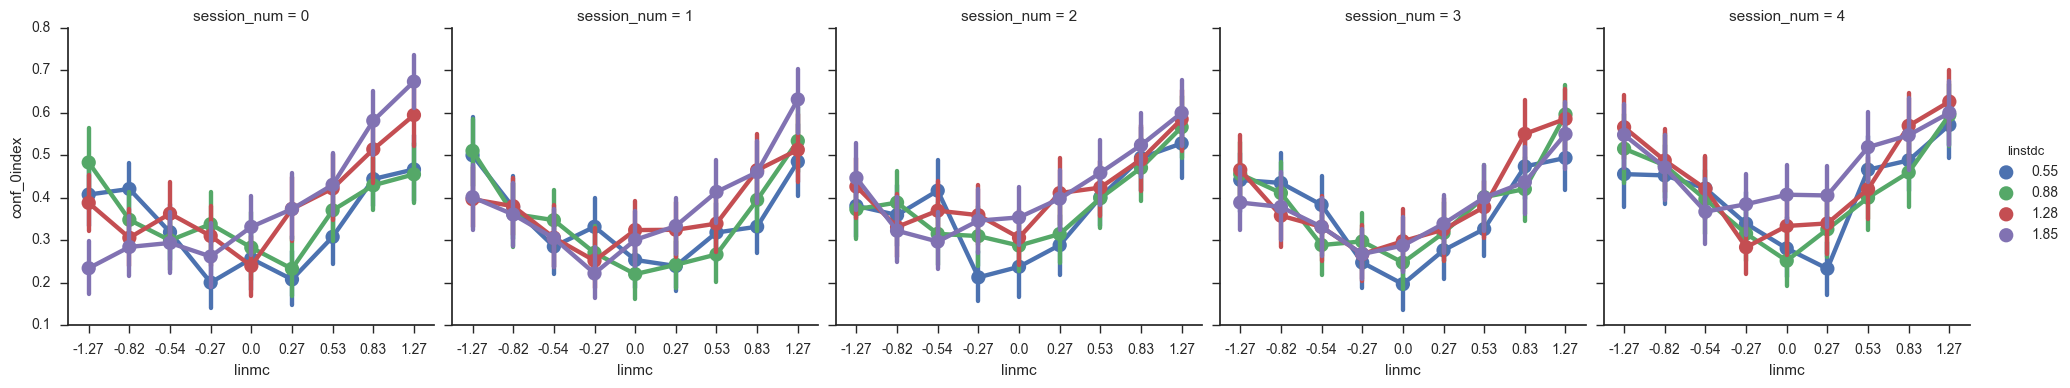

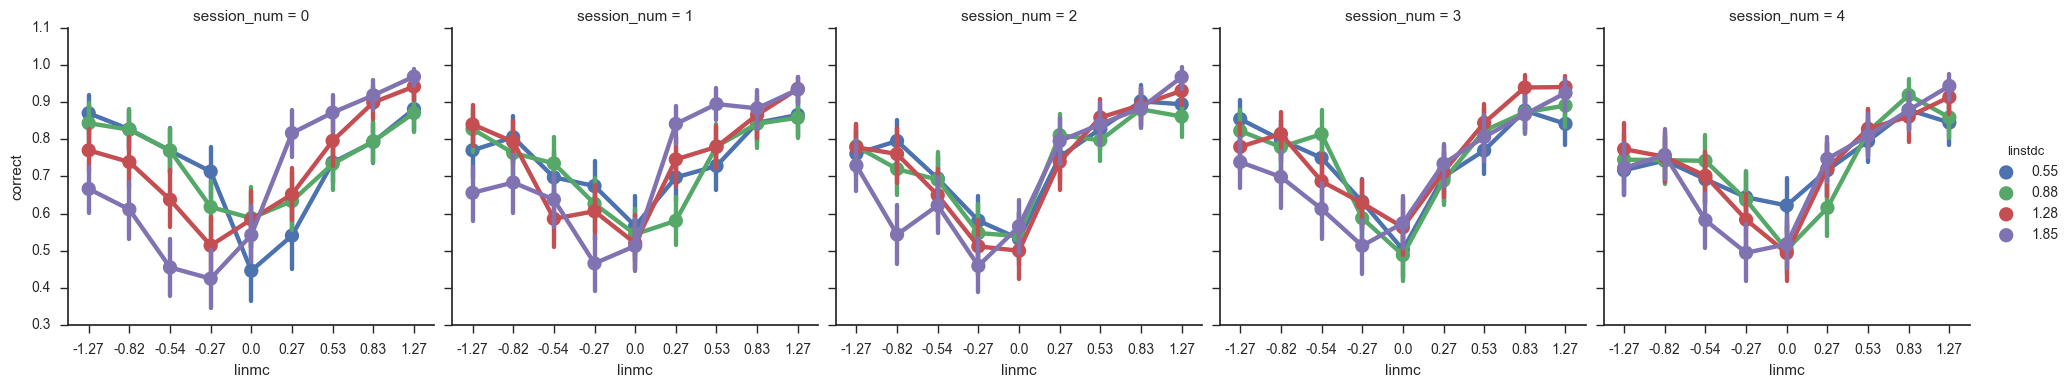

In [27]:
def histify(x, bins, field, name, labels=None):
    if labels is None:
        labels = around([(low + (high-low)/2.) for low, high in zip(bins[:-1], bins[1:])], 2)
    bins = pd.cut(x[field], bins, labels=labels)
    x[name] = bins
    return x

m, s = dz.mc.values, dz.stdc.values
cutoff = prctile(s, linspace(5, 95, 5))
mcut = prctile(m, linspace(5, 95, 10))
data = histify(dz, cutoff, 'stdc', 'linstdc')
data = histify(dz, mcut, 'mc', 'linmc')

sns.factorplot(x='linmc', y='conf_0index', hue='linstdc', unit='snum', data=dz, col='session_num')
sns.factorplot(x='linmc', y='correct', hue='linstdc', unit='snum', data=dz, col='session_num')


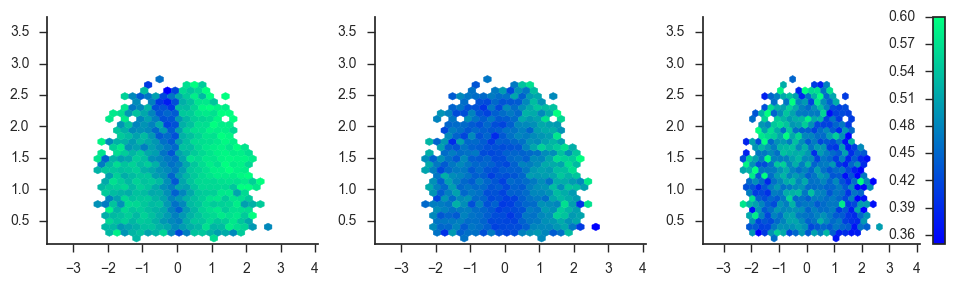

In [28]:
figure(figsize=(10, 3))
subplot(1,3,1)
hexbin(dz.mc.values, data.stdc.values, 
       data.correct, mincnt=10, cmap=winter(),
       gridsize=35)
#xlim([0.25, .75])
#ylim([0, .3])
subplot(1,3,2)
hexbin(dz.mc.values, data.stdc.values, 
       data.confidence.values-1, mincnt=10, cmap=winter(),
       gridsize=35)
#xlim([0.25, .75])
#ylim([0, .3])

subplot(1,3,3)
hexbin(dz.mc.values, data.stdc.values, 
       data.choice_rt, mincnt=10, cmap=winter(),
       gridsize=35, vmin=0.35, vmax=0.6)
#xlim([0.25, .75])
#ylim([0, .3])
colorbar()
sns.despine()
tight_layout()

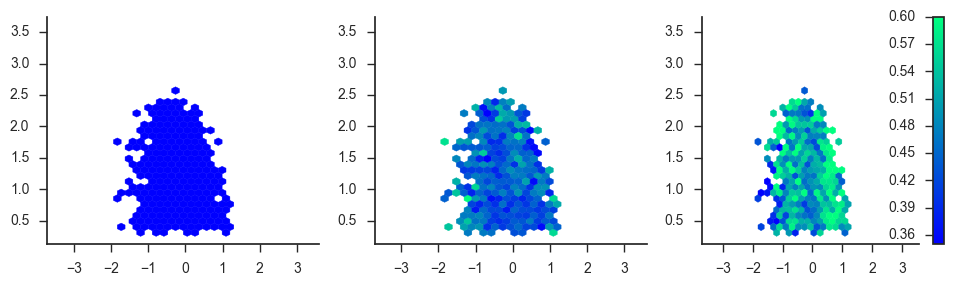

In [29]:
d = dz.query('correct==0')
figure(figsize=(10, 3))

subplot(1,3,1)
hexbin(d.mc.values, d.stdc.values, 
       d.correct, mincnt=10, cmap=winter(),
       gridsize=35)
#xlim([0.25, .75])
#ylim([0, .3])
subplot(1,3,2)
hexbin(d.mc.values, d.stdc.values, 
       d.confidence.values-1, mincnt=10, cmap=winter(),
       gridsize=35)
#xlim([0.25, .75])
#ylim([0, .3])

subplot(1,3,3)
hexbin(d.mc.values, d.stdc.values, 
       d.choice_rt, mincnt=10, cmap=winter(),
       gridsize=35, vmin=0.35, vmax=0.6)
#xlim([0.25, .75])
#ylim([0, .3])
colorbar()
sns.despine()
tight_layout()

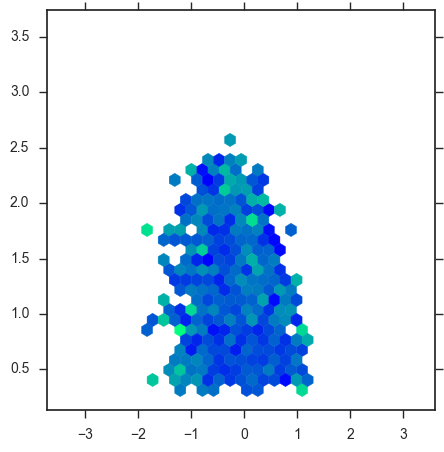

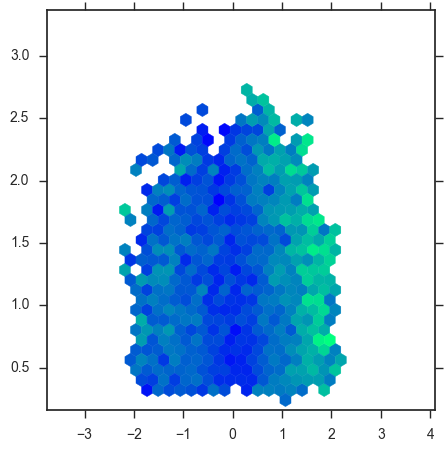

In [30]:
d = dz.query('correct==0')
figure(figsize=(5, 5))

hexbin(d.mc.values, d.stdc.values, 
       d.confidence.values-1, mincnt=10, cmap=winter(),
       gridsize=35)
d = dz.query('correct==1')
figure(figsize=(5, 5))

hexbin(d.mc.values, d.stdc.values, 
       d.confidence.values-1, mincnt=10, cmap=winter(),
       gridsize=35)

In [31]:
## Confidence inversley correlated with RT. How does this look for different sessions?

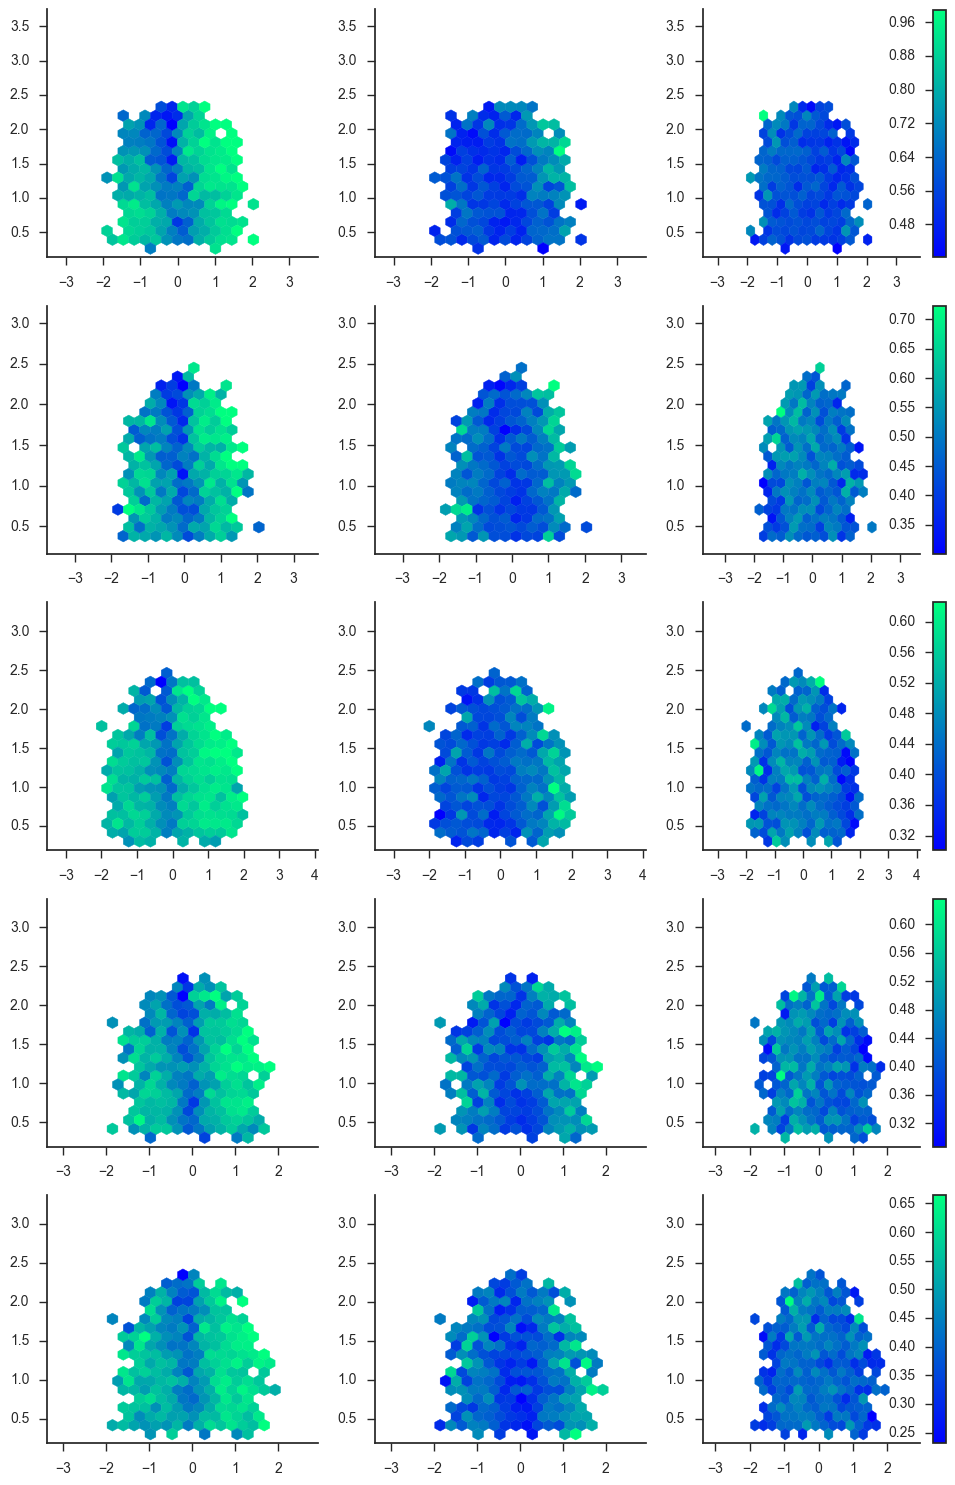

In [32]:
figure(figsize=(10, 15))
for s, d in dz.groupby('session_num'):
    cnt = 1+ s*3
    subplot(5,3, cnt+0)
    hexbin(d.mc.values, d.stdc.values, 
           d.correct, mincnt=10, cmap=winter(),
           gridsize=25)
    #xlim([0.25, .75])
    #ylim([0, .3])
    subplot(5,3,cnt+1)
    hexbin(d.mc.values, d.stdc.values, 
           d.confidence.values-1, mincnt=10, cmap=winter(),
           gridsize=25)
    #xlim([0.25, .75])
    #ylim([0, .3])

    subplot(5,3,cnt+2)
    hexbin(d.mc.values, d.stdc.values, 
           d.choice_rt, mincnt=10, cmap=winter(),
           gridsize=25)
    #xlim([0.25, .75])
    #ylim([0, .3])
    colorbar()
sns.despine()
tight_layout()